In [1]:
import sys
import torch
import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss
from torch.optim import Adam

from math import floor

from torch.utils.data import SubsetRandomSampler

import torch.nn.functional as F

sys.path.append("../")
from net import MNISTNet

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
#    transforms.Normalize((0.5,), (0.5,))
])
batch_size=128
seed = 12131415

# Download and load the training data
training_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

train_size = len(training_set)
valid_size = 0.2
split_point = int(floor(valid_size * train_size))
indices = list(range(train_size))

tr_idx, vl_idx = indices[split_point:], indices[:split_point]

tr_sampler = SubsetRandomSampler(tr_idx, generator = torch.Generator().manual_seed(seed))
vl_sampler = SubsetRandomSampler(vl_idx, generator = torch.Generator().manual_seed(seed))

training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, sampler=tr_sampler)
validation_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, sampler=vl_sampler)



In [3]:
device = 'cuda'
net = MNISTNet(device=device)
net.load_state_dict(torch.load("./models/mnist/student"))


<All keys matched successfully>

In [4]:
def compute_accuracy(loader):
    net.eval()
    running_loss = 0.0
    for (i, data) in enumerate(loader):
        x, y = data
        x = x.to(device)
        preds = net(x)
        running_loss += (y == F.softmax(preds.cpu(), 1).max(1)[1]).to(torch.int64).sum().item()
    return running_loss
print("Accuracy on Training:", compute_accuracy(training_loader) / len(tr_idx))    
print("Accuracy on Validation:", compute_accuracy(validation_loader) / len(vl_idx))    
print("Accuracy on Test:", compute_accuracy(test_loader) / len(test_set))    

Accuracy on Training: 0.9487291666666666
Accuracy on Validation: 0.941
Accuracy on Test: 0.944


In [5]:
X  = test_set.data.view(-1, 1, 28, 28).to(torch.float32)
y = test_set.targets
net = net.to('cpu')

preds = net(X)


In [6]:
X.shape

torch.Size([10000, 1, 28, 28])

In [133]:
v = (torch.full((3, 28 * 28), 0.5) )
W = ((X.view(-1, 28 * 28).repeat(3, 1) + v.repeat_interleave(X.shape[0], dim=0)).tanh() + 1) / 2
print(W.shape)

torch.Size([30000, 784])


In [134]:
preds = F.softmax(net(W.view(-1, 1, 28, 28)), dim=1)

In [135]:
test_set.targets.shape

torch.Size([10000])

In [136]:
preds

tensor([[0.0000e+00, 7.2237e-24, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.3981e-32, 1.0000e+00, 3.5088e-40,  ..., 1.3025e-21, 4.0872e-37,
         6.2444e-36],
        [0.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 1.1178e-39, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.3645e-36, 1.9338e-05, 3.3383e-39,  ..., 9.9998e-01, 5.4090e-43,
         4.2557e-42],
        [2.9204e-36, 1.0000e+00, 0.0000e+00,  ..., 4.3054e-21, 8.8282e-44,
         1.2606e-41],
        [1.6764e-24, 1.7365e-17, 5.5948e-32,  ..., 1.0000e+00, 8.8108e-37,
         8.8806e-29]], grad_fn=<SoftmaxBackward0>)

In [137]:
preds[:20], test_set.targets[:2]

(tensor([[0.0000e+00, 7.2237e-24, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.3981e-32, 1.0000e+00, 3.5088e-40, 1.2270e-37, 1.1273e-38, 2.9423e-32,
          1.5098e-37, 1.3025e-21, 4.0872e-37, 6.2444e-36],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 1.1178e-39, 0.0000e+00, 0.0000e+00],
         [1.6521e-42, 1.4574e-43, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 1.0000e+00, 0.0000e+00, 1.2612e-44],
         [1.5208e-40, 3.0051e-31, 1.9044e-39, 4.2039e-45, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 1.0000e+00, 1.4013e-45, 1.8972e-41],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 2.8728e-41, 0.0000e+00, 0.0000e+00],
         [3.6509e-34, 1.2137e-11, 3.3087e-31, 2.9209e-35, 1.7493e-31, 3.3127e-37,
          8.6909e-42, 1.0000e+00, 6.3881e-36, 5.5615e-33],
         [2.0

In [138]:
preds.shape

torch.Size([30000, 10])

In [139]:
preds.max(dim=1)[0].view(3, -1).shape

torch.Size([3, 10000])

In [140]:
preds.shape


torch.Size([30000, 10])

In [142]:

p1 = preds.gather(1, test_set.targets.repeat(v.shape[0]).view(-1, 1)).view(3, -1).log() 

mask = torch.ones_like(preds, dtype=torch.bool)
mask[torch.arange(mask.shape[0]), test_set.targets.repeat(v.shape[0]).view(-1)] = False

p2 = preds[mask].view(mask.shape[0], -1).log().max(1)[0].view(3, -1)

print(p1 - p2)

torch.maximum(p1 - p2, torch.zeros_like(p1))


#print(p2)
#pz = torch.zeros_like(pp)
#torch.maximum(preds.gather(1, test_set.targets.repeat(v.shape[0]).view(-1, 1)).view(3, -1).log() - preds.log().max(dim=1)[0].view(3, -1), pz) #- preds.log().max(dim=1)[0].view(3, -1)

tensor([[ 53.2847, -90.8481,  89.6894,  ...,     -inf, -92.2265, -98.3517],
        [ 53.2847, -90.8481,  89.6894,  ...,     -inf, -92.2265, -98.3517],
        [ 53.2847, -90.8481,  89.6894,  ...,     -inf, -92.2265, -98.3517]],
       grad_fn=<SubBackward0>)


tensor([[53.2847,  0.0000, 89.6894,  ...,  0.0000,  0.0000,  0.0000],
        [53.2847,  0.0000, 89.6894,  ...,  0.0000,  0.0000,  0.0000],
        [53.2847,  0.0000, 89.6894,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<MaximumBackward0>)

In [98]:
mask = torch.ones_like(preds)
mask[torch.arange(mask.shape[0]), test_set.targets.repeat(v.shape[0]).view(-1)] = False



tensor([[1., 1., 1.,  ..., 0., 1., 1.],
        [1., 1., 0.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [104]:
preds.shape, mask.shape

preds[mask.to(torch.bool)].view(mask.shape[0], -1)

torch.Size([30000, 9])

In [84]:
print(F.softmax(preds, 1).max(1)[1].view(-1, X.shape[0]))

tensor([[7, 2, 1,  ..., 4, 5, 6],
        [7, 2, 1,  ..., 4, 5, 6],
        [7, 2, 1,  ..., 4, 5, 6]])


In [85]:
Y = F.softmax(preds, 1)
print(Y.shape)

torch.Size([30000, 10])


In [17]:
v = torch.eye(3, 28 * 28)
W = X.view(-1, 28 * 28).repeat(3, 1) + v.repeat_interleave(X.shape[0], dim=0)
print(W.shape)

torch.Size([30000, 784])


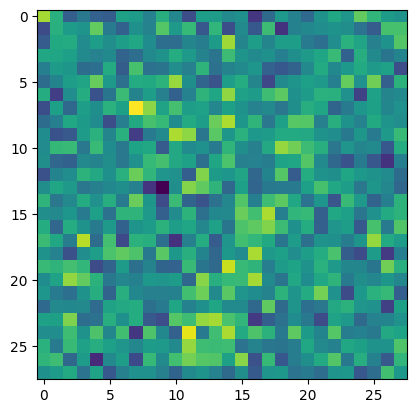

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(W[0].view(28, 28))

Original:  9
Modified:  9


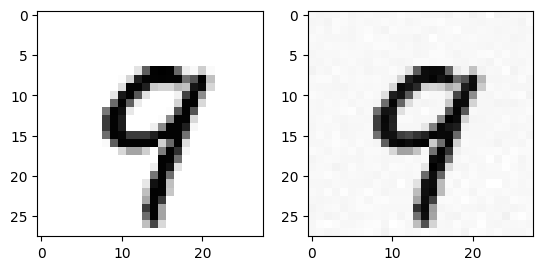

In [37]:
import matplotlib.pyplot as plt

x  = test_set.data[12]
net = net.to('cpu')
print("Original: ", F.softmax(net(x.view(1, 1, 28, 28).to(torch.float32)), 1).max(1)[1].item())

v =  5 * torch.randn(28 * 28)

w = (x.view(-1) + v).view(28, 28)
print("Modified: ", F.softmax(net(w.view(1, 1, 28, 28).to(torch.float32)), 1).max(1)[1].item())

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x.view(28,28), cmap='Grays')
ax2.imshow(w, cmap='Grays')